In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras.backend as K #to define custom loss function

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

In this code snippet, we're working with two datasets — a training set and a testing set — using the pandas library. These datasets are represented as CSV (Comma Separated Values) files named 'train.csv' and 'test.csv', respectively, both located in the directory '../input/mayo-clinic-strip-ai/'. The first line of code reads the 'train.csv' file and loads it into a DataFrame object called train_df. Similarly, the second line reads the 'test.csv' file and loads it into a DataFrame object called test_df. DataFrame is a two-dimensional labeled data structure with columns of potentially different types, it's one of the primary data structures in pandas. After loading the data, the first five rows of the training dataset are displayed using the head() method in train_df.head(). Displaying the first few rows of a dataset is a common practice in data analysis, providing a quick overview of the data structure, column names, and initial data points.

## Data Download

The data is downloaded manually from kaggle in the following link: https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data

In [54]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [4]:
len(train_df) + len(test_df)

758

## Exploratory Data Analysis

This Python code snippet uses the Matplotlib and Seaborn libraries to generate two bar plots showing the distribution of data in a pandas DataFrame named train_df. The plot style is set to 'Solarize_Light2' using plt.style.use.

The first plot visualizes the relative frequency of each category in the 'label' column of the DataFrame, expressed as a percentage of the total. This can be interpreted as the distribution of a target variable across different categories.

The second plot shows the relative frequency of each 'center_id' in the DataFrame, which could represent the number of images provided by different clinic centers, again expressed as a percentage of the total.

Finally, the script prints out the size (i.e., the number of rows) of both the training DataFrame (train_df) and the testing DataFrame (test_df).






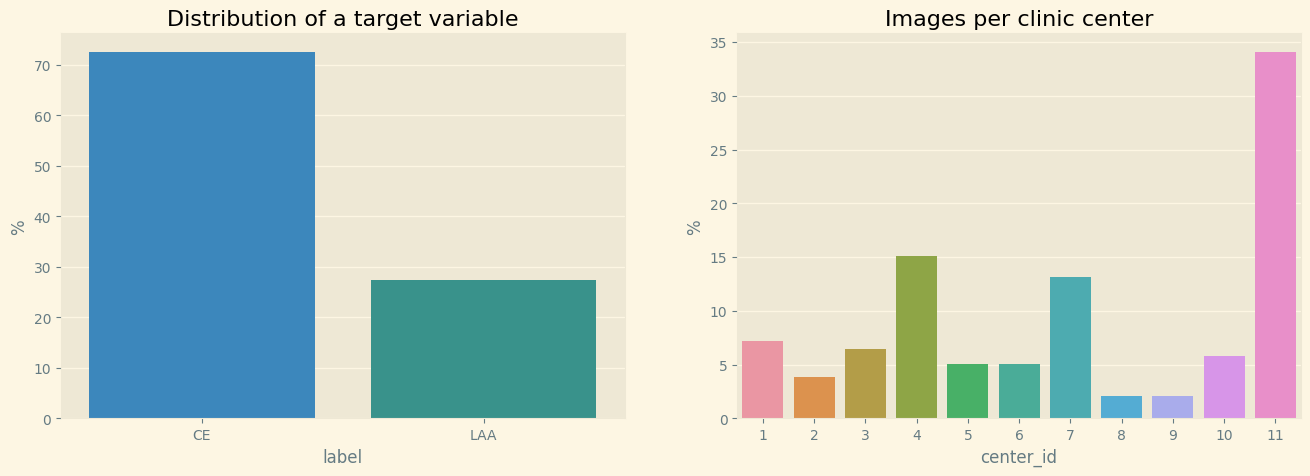

Train Size = 754
Test Size = 4


In [53]:
plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))



## From this plot we notice that there is a class imbalance which we will deal with later in this notebook

The provided Python code uses the glob function from the glob module to fetch all the image file paths from specified directories in the Kaggle dataset titled 'mayo-clinic-strip-ai'.

The images are divided into three directories: 'train', 'test', and 'other'. Each directory's file paths are stored in the train_images, test_images, and other_images lists respectively.

The script then prints the number of images in each set. The len() function counts the number of items (image file paths in this case) in each list, thereby providing the total number of images in the training set, the testing set, and the 'other' set.






In [6]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


This Python script iterates over the train_images list, which contains file paths for images in the training dataset. It uses the OpenSlide library to open each image file and extract its properties.

The script gathers the following data for each image:

'image_id': the last twelve characters (excluding the last four) of the image file path are taken as the image ID.
'width' and 'height': the dimensions of the image are obtained from the OpenSlide object.
'size': the file size of the image in megabytes, obtained by using os.path.getsize and converting bytes to megabytes.
'path': the original file path to the image.
The script then creates a pandas DataFrame named image_data from these properties.

An additional column, 'img_aspect_ratio', is created by dividing the width of the image by its height.

The DataFrame is sorted based on the 'image_id' and then reset the index.



In [7]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


This Python code snippet generates two histograms using Matplotlib and Seaborn libraries to visualize data from the image_data DataFrame.

The first histogram shows the distribution of image file sizes, based on the 'size' column of the DataFrame, which represents the size of each image file in megabytes. The data is grouped into 100 bins for the histogram.

The second histogram shows the distribution of image aspect ratios, based on the 'img_aspect_ratio' column of the DataFrame, which represents the aspect ratio of each image (width divided by height). Again, the data is grouped into 100 bins for the histogram.

Each histogram has a title and y-axis label set by set_title and set_ylabel respectively. The plot style is set to 'Solarize_Light2' using plt.style.use.



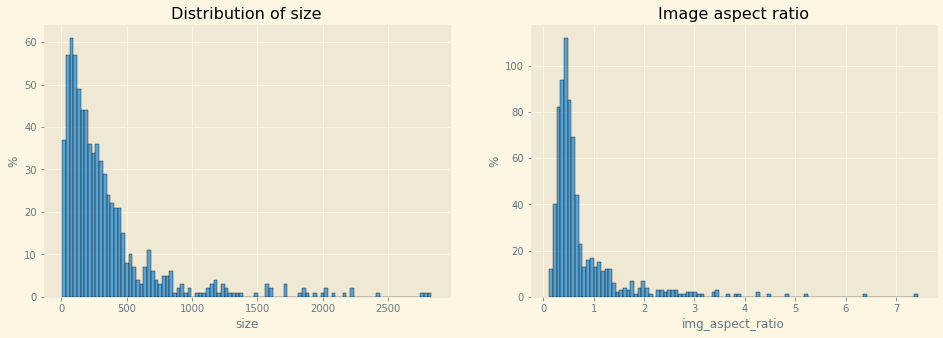

In [8]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

Initially, the code imports the Image class from PIL and sets the MAX_IMAGE_PIXELS attribute to None to disable the library's restriction on the maximum number of pixels an image that it will open can have. This is done because very large images can cause a PIL to consume excessive amounts of memory which might lead to a crash.

Next, it filters the image paths in the image_data DataFrame for images labeled 'CE' and 'LAA' respectively, storing these in CE_imgs and LAA_imgs. These variables now contain the paths of images corresponding to each label.

The script then uses Matplotlib's pyplot (plt) to set the default style for the plots and creates a figure with five subplots arranged in a row with a size of 16x16 inches.

The subsequent for loop picks a random image path from the CE_imgs DataFrame, opens this image using PIL's Image.open() function, and resizes it to a thumbnail size of 300x300 pixels using the thumbnail() function with the LANCZOS resampling filter (a high-quality downsampling filter).

Finally, the processed image is displayed on the corresponding axes with the title "target: CE", and once the loop is done with all five axes, the completed plot is displayed using plt.show(). So, in essence, the code is used for displaying five randomly selected images labeled as 'CE' from a DataFrame containing image paths and labels.






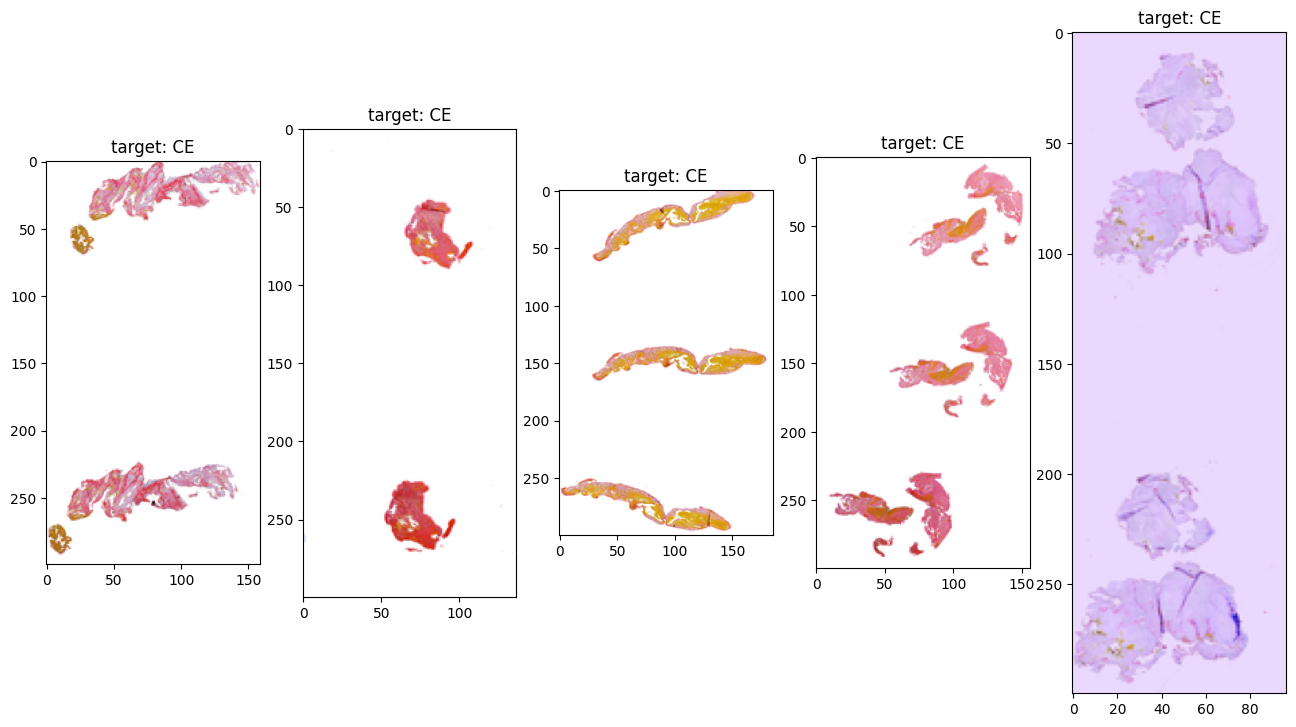

In [9]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']


plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

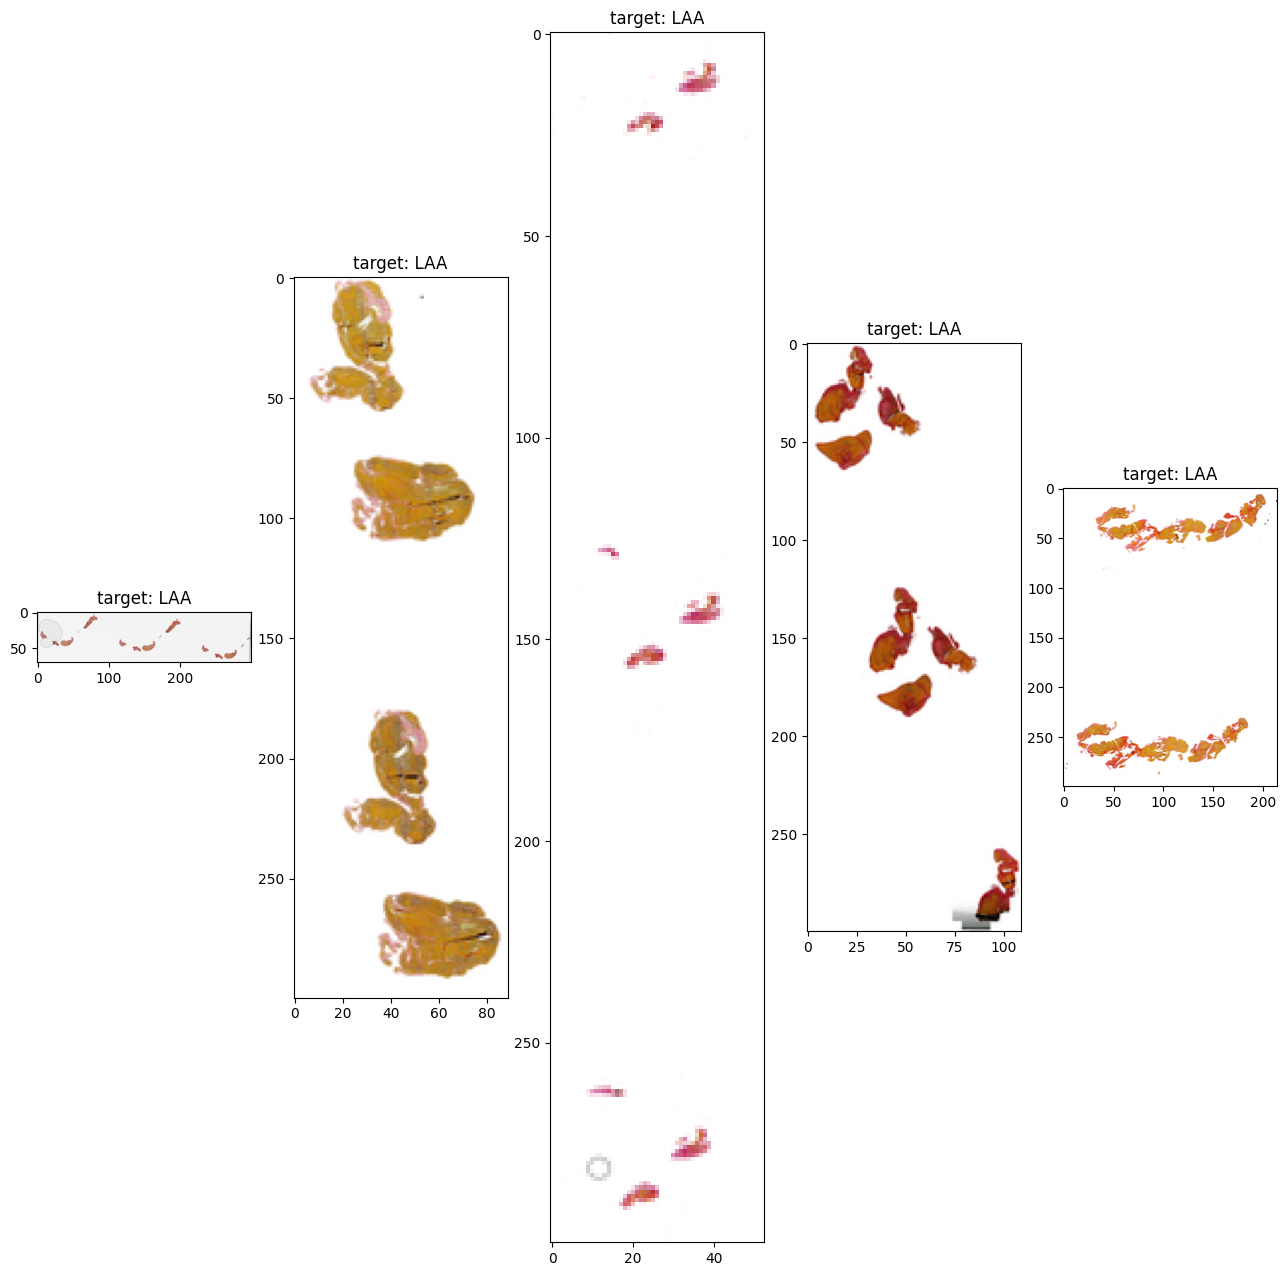

In [10]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

## Initial Observations:


The range of image sizes varies from small to high-resolution.
Images display a variety of aspect ratios.
There is a diversity of background colors.
Blood clots typically appear as numerous small fragments.
The color of blood clots shows notable variation.

In [55]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))



## Loading Data

In [12]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [13]:
# labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


## Preprocessing

The function preprocess() is defined first. This function accepts an image_path as an argument, which is the file path to a specific image. It opens the image using the OpenSlide function and extracts a specified region from the image using the read_region() function. The region starts from the coordinates (2500, 2500) and is of size 5000x5000 pixels. The resulting image is then resized to 128x128 pixels and converted to a numpy array. This function is used to standardize the input images to a uniform size and format.

Following the definition of the preprocess() function, an empty list X_train is created to store the preprocessed training images. The code then iterates over the 'file_path' column of the DataFrame train_df, which contains the paths of training images. Using a progress bar provided by the tqdm function, each image is preprocessed using the preprocess() function and added to the X_train list.



In [14]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 754/754 [48:35<00:00,  3.87s/it] 

CPU times: user 15min 34s, sys: 3min 17s, total: 18min 52s
Wall time: 48min 35s


In [15]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [16]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [17]:
print(x_train.shape)

(603, 128, 128, 4)


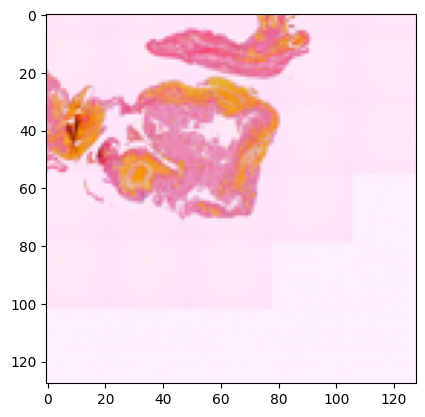

In [18]:
plt.imshow(x_train[0])

# Model Training

## DenseNET

In [38]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


Here, a function named preprocess_RGB() is defined to preprocess images. It accepts an image_path as an argument. The image at the specified path is opened using OpenSlide, a region of the image starting at the coordinates (2500,2500) with a size of 5000x5000 pixels is extracted. The convert('RGB') method is then used to convert the image to RGB mode. This is a necessary step for some models or libraries that expect input images in this format. The image is then resized to 128x128 pixels and converted to a numpy array before being returned by the function.

After defining this function, an empty list X_train is created to hold the preprocessed training images. Then, for each image path in the 'file_path' column of the train_df DataFrame, the preprocess_RGB() function is used to preprocess the image and it is added to the X_train list. The progress of this operation is tracked by the tqdm function, which provides a handy progress bar.



In [39]:
%%time
def preprocess_RGB(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size).convert('RGB')
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    #print(i)
    x1=preprocess_RGB(i)
    X_train.append(x1)
    
Y_train=train_df['target']

100%|██████████| 754/754 [38:17<00:00,  3.05s/it]

CPU times: user 14min 52s, sys: 3min 18s, total: 18min 10s
Wall time: 38min 17s


In [40]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [41]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [42]:
CE = 0
LAA = 0
for i in y_test:
    if i ==1:
        CE = CE+1
    else:
        LAA = LAA + 1
print(CE)
print(LAA)

102
49


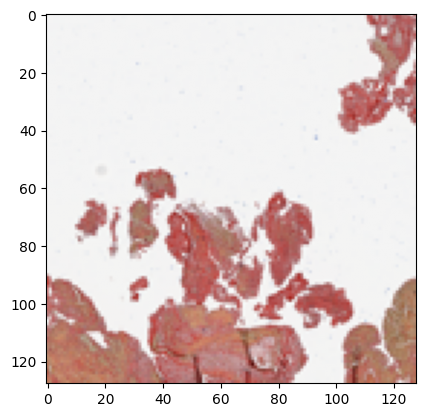

In [43]:
plt.imshow(x_test[0])

In [44]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [45]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.821256038647343, 1: 0.6892138939670932}

This is a DenseNET pretrained model. We are transfer learning on the Mayo Clinic Dataset. 

First, the DenseNet121 model is loaded with pre-trained weights from 'imagenet' using TensorFlow's DenseNet121 function. This model will take images of shape (128,128,3) as input, which matches the preprocessing we've done earlier (images resized to 128x128 pixels in RGB mode). The argument include_top=False specifies that the final fully-connected layer, which is responsible for classification in the original DenseNet121 model, should not be included. This allows us to add custom layers later suitable for our specific task.

After loading the DenseNet121 model, the script prints the total number of layers in the model. It then sets the first 200 layers as trainable and the remaining layers as non-trainable. This is a form of transfer learning, where we leverage the features already learned by the DenseNet121 model on the ImageNet dataset and fine-tune only a subset of them for our specific task.

A new model, Dense_model, is then constructed using the Keras Sequential API. The pre-trained DenseNet121 model is added as the first layer. This is followed by a GlobalAveragePooling2D layer, which will convert the feature maps from DenseNet121 into a single vector that can be input into a fully-connected (Dense) layer. A dropout layer is then added to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. The next layers are two Dense layers with ReLU activation, and finally, a Dense layer with a single unit and sigmoid activation function for binary classification.

In [46]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from keras import layers
from keras import metrics

effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(128,128,3)
)

print(len(effnet.layers))
for layer in effnet.layers[0:200]:
    layer.trainable = True
for layer in effnet.layers[201::]:
    layer.trainable = False

Dense_model = Sequential()
Dense_model.add(effnet)
Dense_model.add(layers.GlobalAveragePooling2D())
Dense_model.add(layers.Dropout(0.5))
Dense_model.add(layers.Dense(512,activation='relu'))
Dense_model.add(layers.Dense(64,activation='relu'))
Dense_model.add(layers.Dense(1, activation='sigmoid'))

Dense_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))

Dense_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
427
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 7,595,201
Trainable params: 2,733,825

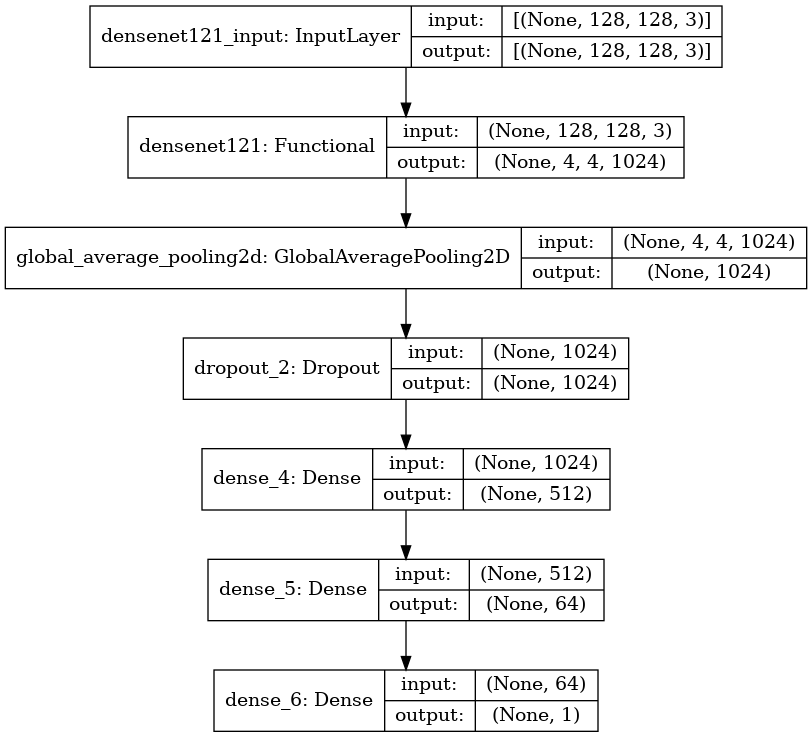

In [47]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(Dense_model, to_file=dot_img_file, show_shapes=True)

In [48]:
callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='Dense_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

# Training

In [49]:
Dense_model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback2   
)

Epoch 1/10
31/31 [==============================] - 18s 233ms/step - loss: 0.7903 - binary_accuracy: 0.5224 - f1_score: 0.5953 - val_loss: 0.6713 - val_binary_accuracy: 0.6225 - val_f1_score: 0.7585

Epoch 00001: val_binary_accuracy improved from -inf to 0.62252, saving model to Dense_best.h5
Epoch 2/10
31/31 [==============================] - 3s 90ms/step - loss: 0.7079 - binary_accuracy: 0.5307 - f1_score: 0.5868 - val_loss: 0.6724 - val_binary_accuracy: 0.6291 - val_f1_score: 0.7705

Epoch 00002: val_binary_accuracy improved from 0.62252 to 0.62914, saving model to Dense_best.h5
Epoch 3/10
31/31 [==============================] - 3s 96ms/step - loss: 0.7015 - binary_accuracy: 0.5622 - f1_score: 0.6086 - val_loss: 0.7681 - val_binary_accuracy: 0.3311 - val_f1_score: 0.0167

Epoch 00003: val_binary_accuracy did not improve from 0.62914
Epoch 4/10
31/31 [==============================] - 3s 94ms/step - loss: 0.6870 - binary_accuracy: 0.6269 - f1_score: 0.7345 - val_loss: 0.6814 - val_b

# Evaluation

In [50]:
best_Dense = load_model('/kaggle/working/Dense_best.h5', custom_objects={"f1_score": f1_score })
best_Dense.evaluate(x_test,y_test)

5/5 [==============================] - 4s 272ms/step - loss: 0.6724 - binary_accuracy: 0.6291 - f1_score: 0.7686


[0.6724172234535217, 0.6291390657424927, 0.7685613632202148]

## Confusion Matrix

Text(0.5, 25.722222222222214, 'Actual')

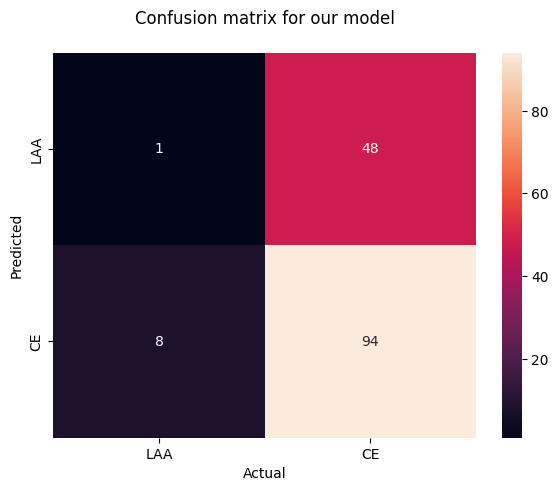

In [52]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_Dense.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel("Predicted")
plt.xlabel("Actual")